# Single-Shell Three-Tissue Constrained Spherical Deconvolution

Multi-Tissue CSD (MT-CSD), or what *Jeurissen et al. (2014)* refers to as Multi-Shell Multi-Tissue CSD (MSMT-CSD), is in extension of regular CSD algorithm. In MT-CSD, Aside from the standard white matter convolution kernel, also a CSF and grey matter kernel are estimated from the data, and fitted simultaneously fitted for better FOD estimation.

$$
\begin{equation}
 E_{\textrm{MT-CSD}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{CSF}}+ \underbrace{f_{\textrm{GM}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{Grey Matter}} + \underbrace{f_r\left[\overbrace{\operatorname{FOD}(\operatorname{SH}|l_{\textrm{max}})}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\overbrace{E_{\textrm{WM}}(\cdot)}^{\textrm{Anisotropic Response}}\right]}_{\textrm{White Matter}}
\end{equation}
$$

Normally, since we are fitting 3 different compartments, we would need multi-shell data to estimate meaningful volume fractions. However, *Dhollander et al. (2016)* proposed an iterative bi-convex optimization strategy that allows to estimate the three-tissue CSD algorithm (WM + GM + CSF) from single-shell data (1 shell + b0), that at least looks similar to the multi-shell result.

The algorithm is fairly simple and can be very simply implemented using Dmipy. It consists of 2 steps:  
- 1: Fix the WM fraction to 0. and estimate (GM + CSF), this results in an overestimation of CSF.
- 2: Estimate WM + GM while fixing CSF to the result of the previous step.

In the next iteration the WM fraction is fixed to the result of the 2nd step of the previous iteration. Specifically, *Dhollander et al.* say 4 iterations of this algorithm is enough to get multi-shell results out of single-shell data. In this example, we will implement this algorithm, study a bit why this is so and if it actually works.

## Data Preparation for single-shell data from multi-shell HCP data

First, we prepare some single-shell data from the multi-shell HCP slice that we use for examples.

In [1]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [2]:
scheme_hcp.print_acquisition_info

Acquisition scheme summary

total number of measurements: 288
number of b0 measurements: 18
number of DWI shells: 3

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |0               |0                        |10.6       |43.1      |N/A  
1           |90        |1000            |56                       |10.6       |43.1      |N/A  
2           |90        |2000            |79                       |10.6       |43.1      |N/A  
3           |90        |3000            |97                       |10.6       |43.1      |N/A  


Using Dmipy, cutting shells out of acquisition schemes and the corresponding data is very easy. You can use the `scheme.return_pruned_acquisition_scheme()` function and give the shells you want, and it will return the pruned scheme (and the pruned data if you optionally give it).

For this example we will make 3 datasets of single-shell data (b0 + b1000, b0 + b2000 and b0 + b3000), so we can study the effect of Dhollander's algorithms.

In [3]:
scheme_01_shell, data_01_shell = scheme_hcp.return_pruned_acquisition_scheme([0, 1], data_hcp)
scheme_02_shell, data_02_shell = scheme_hcp.return_pruned_acquisition_scheme([0, 2], data_hcp)
scheme_03_shell, data_03_shell = scheme_hcp.return_pruned_acquisition_scheme([0, 3], data_hcp)
schemes = [scheme_01_shell, scheme_02_shell, scheme_03_shell, scheme_hcp]
data = [data_01_shell, data_02_shell, data_03_shell, data_hcp]

Notice that the pruned acquisition schemes are indeed subsets of the multi-shell one

In [4]:
scheme_02_shell.print_acquisition_info

Acquisition scheme summary

total number of measurements: 108
number of b0 measurements: 18
number of DWI shells: 1

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |0               |0                        |10.6       |43.1      |N/A  
1           |90        |2000            |79                       |10.6       |43.1      |N/A  


## Unsupervised single-shell multi-tissue response function estimation

The unsupervised algorithm that we used to estimate multi-tissue response functions from multi-shell data in the [MT-CSD example](http://nbviewer.jupyter.org/github/AthenaEPI/dmipy/blob/master/examples/example_multi_tissue_constrained_spherical_deconvolution.ipynb) can also be used for single-shell data. We will simply apply it to our 4 data sets (3 single-shell and the original multi-shell) and get the response functions.

In [5]:
from dmipy.tissue_response.three_tissue_response import three_tissue_response_dhollander16
tissue_responses = []
selection_maps = []
for scheme, data_ in zip(schemes, data):
    wm, gm, csf, selection_map = three_tissue_response_dhollander16(
        scheme, data_, wm_algorithm='tournier07',
        wm_N_candidate_voxels=150, gm_perc=0.2, csf_perc=0.4)
    tissue_responses.append([wm, gm, csf])
    selection_maps.append(selection_map)

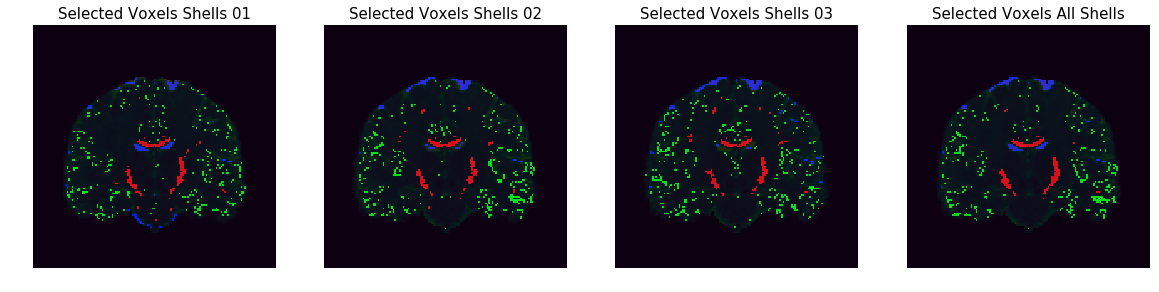

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(figsize=[20, 5], ncols=4)
axs = axs.ravel()

for ax, selection_map, txt in zip(axs, selection_maps, ['Shells 01', 'Shells 02', 'Shells 03', 'All Shells']):
    ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
    ax.imshow(selection_map.squeeze().transpose((1, 0, 2)), origin=True, alpha=0.8)
    ax.set_axis_off()
    ax.set_title('Selected Voxels {}'.format(txt), fontsize=15);

Notice that the selected voxels for the response functions (red for WM, green for WM and blue for CSF) are very similar for the 4 different data sets. When we visualize the resulting response function we can see that everything looks very coherent:

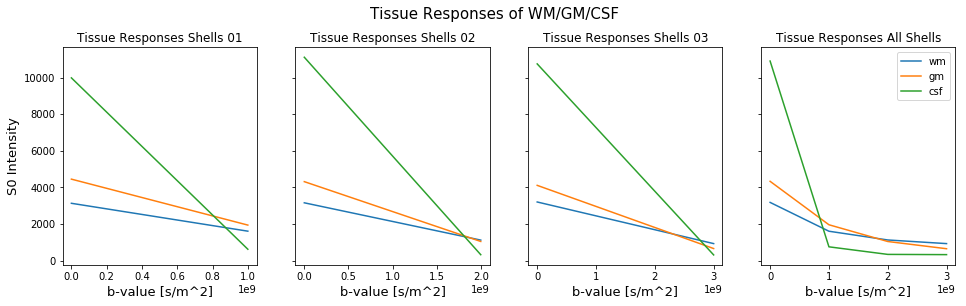

In [7]:
fig, axs = plt.subplots(figsize=[16, 4], ncols=4, sharey=True)
fig.suptitle('Tissue Responses of WM/GM/CSF', fontsize=15, y=1.02)
axs = axs.ravel()
axs[0].set_ylabel('S0 Intensity', fontsize=13)
for ax, scheme, tissue_response, txt in zip(
        axs, schemes, tissue_responses, ['Shells 01', 'Shells 02', 'Shells 03', 'All Shells']):
    for response, name in zip(tissue_response, ['wm', 'gm', 'csf']):
        ax.plot(scheme.shell_bvalues, response.tissue_response(), label=name)
    ax.set_xlabel('b-value [s/m^2]', fontsize=13)
    ax.set_title('Tissue Responses {}'.format(txt))
axs[3].legend();

## Dmipy implementation of Single-Shell Three-Tissue CSD

The implementation of the single-shell multi-tissue algorithm is very straight-forward in Dmipy. We will describe the essential code that does the iteration here in the text but will import the function itself from the package to not clutter this example with documentation.

```
N_iterations = 4  # if we follow Dhollander16
for it in range(N_iterations):
    # step one: fix WM and fit GM + CSF
    mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_responses)
    if it == 0:
        mt_csd_mod.set_fixed_parameter('partial_volume_0', np.zeros(data.shape[:-1]))
    else:
        mt_csd_mod.set_fixed_parameter(
            'partial_volume_0', mt_csd_fit.fitted_parameters['partial_volume_0'])
    mt_csd_fit = mt_csd_mod.fit(**fit_args)

    # step two: fix CSF and fit WM + GM
    mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_responses)
    mt_csd_mod.set_fixed_parameter(
        'partial_volume_2', mt_csd_fit.fitted_parameters['partial_volume_2'])
    mt_csd_fit = mt_csd_mod.fit(**fit_args)
```

This is the whole trick - you can see it's very painless to implement. 

At each step we re-initiate the `MultiCompartmentSphericalHarmonicsModel` and fix the required volume fraction using `set_fixed_parameter()`. In this case we assume that `volume_fraction_0` and `volume_fraction_2` correspond to WM and CSF, respectively.

We'll import the algorithm directly to use it in our experiments:

In [8]:
from dmipy.custom_optimizers.single_shell_three_tissue_csd import single_shell_three_tissue_csd

# Synthetic Analysis of why this algorithm seems to work
We use the tissue-response functions that we estimated from the different datasets to analyze why it appears to be possible to estimate multi-shell-quality results from single-shell data.

As a simple experiment, we will generate some synthetic data where all fractions are equal to 1/3, start the algorithm, save the volume fractions at every step and plot them over iterations. We will also naively fit the MT-CSD model directly on the single-shell data as comparison.

In [9]:
import numpy as np
def generate_synthetic_multi_tissue_data(acquisition_scheme, tissue_responses, fractions=None):
    "Function to generate synthetic data from given tissue responses"
    if fractions is None:
        fractions = np.random.rand(len(tissue_responses))
        fractions /= fractions.sum()
    data = 0.
    for vf, response in zip(fractions, tissue_responses):
        data += vf * response.S0_response * response(acquisition_scheme, mu=[0., 0.])
    data =  np.array([data])
    return fractions, data

def get_fractions(csd_fits):
    "Helper function to get the fractions from a list of fitted MT-CSD objects"
    partial_volumes = []
    for fit in csd_fits:
        partial_volumes.append([
            fit.fitted_and_linked_parameters[fit.model.partial_volume_names[0]],
            fit.fitted_and_linked_parameters[fit.model.partial_volume_names[1]],
            fit.fitted_and_linked_parameters[fit.model.partial_volume_names[2]]])
    fractions = np.array(partial_volumes).squeeze().T
    return fractions

In the following code we perform the experiment and directly plot the results for each of the 3 single-shell datasets.

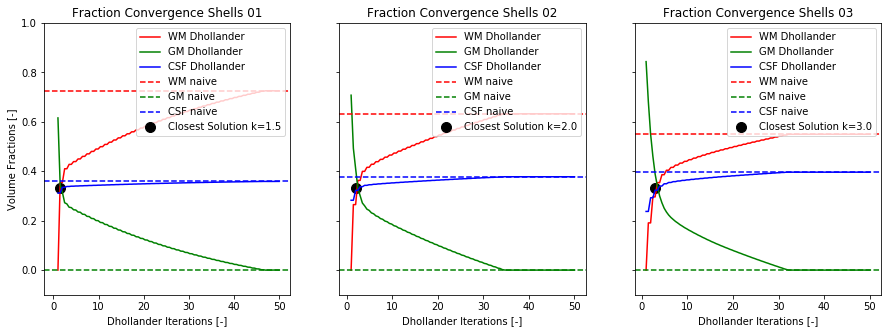

cvxpy found infeasible problem
cvxpy found infeasible problem
cvxpy found infeasible problem
cvxpy found infeasible problem


In [10]:
from dmipy.core.modeling_framework import MultiCompartmentSphericalHarmonicsModel

gt_fractions = [1/3., 1/3., 1/3.]
N_iterations = 50
its = np.linspace(1, 50, 100)
texts = ['Shells 01', 'Shells 02', 'Shells 03']

fig, axs = plt.subplots(figsize=[15, 5], ncols=3, sharey=True)
axs = axs.ravel()

axs[0].set_ylabel('Volume Fractions [-]')
axs[0].set_ylim(-0.1, 1)
for ax, scheme, tissue_response, txt in zip(axs, schemes, tissue_responses, texts):
    _, data_test = generate_synthetic_multi_tissue_data(scheme, tissue_response, gt_fractions)
    fits = single_shell_three_tissue_csd(
        scheme, data_test, tissue_response, N_iterations=N_iterations,
        return_all_csd_fits=True, ss3t_verbose=False)
    estimated_fractions = get_fractions(fits)
    closest_index = (np.argmin(np.sum((estimated_fractions - 1/3.) ** 2, axis=0)) + 1) / 2.
    
    mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_response)
    naive_fit = mt_csd_mod.fit(scheme, data_test, fit_S0_response=True, verbose=False)
    
    ax.plot(its, estimated_fractions[0], c='r', label='WM Dhollander')
    ax.plot(its, estimated_fractions[1], c='g', label='GM Dhollander')
    ax.plot(its, estimated_fractions[2], c='b', label='CSF Dhollander')
    ax.axhline(naive_fit.fitted_parameters['partial_volume_0'], c='r', ls='--', label='WM naive')
    ax.axhline(naive_fit.fitted_parameters['partial_volume_1'], c='g', ls='--', label='GM naive')
    ax.axhline(naive_fit.fitted_parameters['partial_volume_2'], c='b', ls='--', label='CSF naive')
    ax.scatter(closest_index, 1/3., s=100, c='k', label='Closest Solution k={}'.format(closest_index))
    ax.set_xlabel('Dhollander Iterations [-]')
    ax.set_title('Fraction Convergence {}'.format(txt))
    ax.legend(loc='upper right')

In each plot continuous lines are the Dhollander (iterative) results and the the dashed horizontal lines are the naive fitting results. The black dot represents the point where the iterative solution is closest to the ground truth (volume fraction 1/3 for all).

Notice that the iterative fitting process converges to the naive fitting solution for the b=2000 and b=3000 single-shell datasets. This makes sense since the problem is convex and has the same minimum also in this iterative setting. It probably doesn't happen for the b=1000 dataset as there's too little contrast in the data. Notice that for the higher b-value data **the GM fraction always converges towards zero**.

It seems that the whole trick to this algorithm is the observation that when initializing with WM=0, then the iterative process will pass through the true (multi-shell) solution, or at least something close to it. Heuristically, this point seems to come after around 2-3 iterations (at least for these volume fractions), **but depends on b-value**.

It seems this algorithm can be improved by finding a way to choose when to stop optimizing depending on the b-value and tissue composition.

# Comparison of 1-shell (bmax=1k, 2k, 3k) versus 3-shell MT-CSD

We can now try a similar comparison on some real data of the HCP. We fit the iterative algorithm to each of the single-shell datasets and compare it with the actual multi-shell fit.

In [11]:
full_fits = []
for scheme, data, tissue_response in zip(
        schemes[:-1], data[:-1], tissue_responses[:-1]):
    full_fits.append(single_shell_three_tissue_csd(
        scheme, data, tissue_response, N_iterations=4,
        return_all_csd_fits=True, csd_fit_verbose=False))

# we also fit the MT-CSD model to the multi-shell data as comparison
mtcsd_mod_3shell = (
    MultiCompartmentSphericalHarmonicsModel(tissue_responses[-1]))
mtcsd_fit_3shell = mtcsd_mod_3shell.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0, fit_S0_response=True)

finish it 1 of 4 in 475 seconds
finish it 2 of 4 in 412 seconds
finish it 3 of 4 in 410 seconds
finish it 4 of 4 in 411 seconds
finish it 1 of 4 in 407 seconds
finish it 2 of 4 in 405 seconds
finish it 3 of 4 in 407 seconds
finish it 4 of 4 in 408 seconds
finish it 1 of 4 in 374 seconds
finish it 2 of 4 in 392 seconds
finish it 3 of 4 in 394 seconds
finish it 4 of 4 in 394 seconds
Setup CVXPY FOD optimizer in 0.0116019248962 seconds
Using parallel processing with 8 workers.
Fitting of 8181 voxels complete in 318.064360142 seconds.
Average of 0.0388784207483 seconds per voxel.


## Volume Fraction Comparison
In this section we get the volume fractions out of the fitted MT-CSD models and visualize them as RGB maps (red WM, green WM, blue CSF), as the iterations go by.

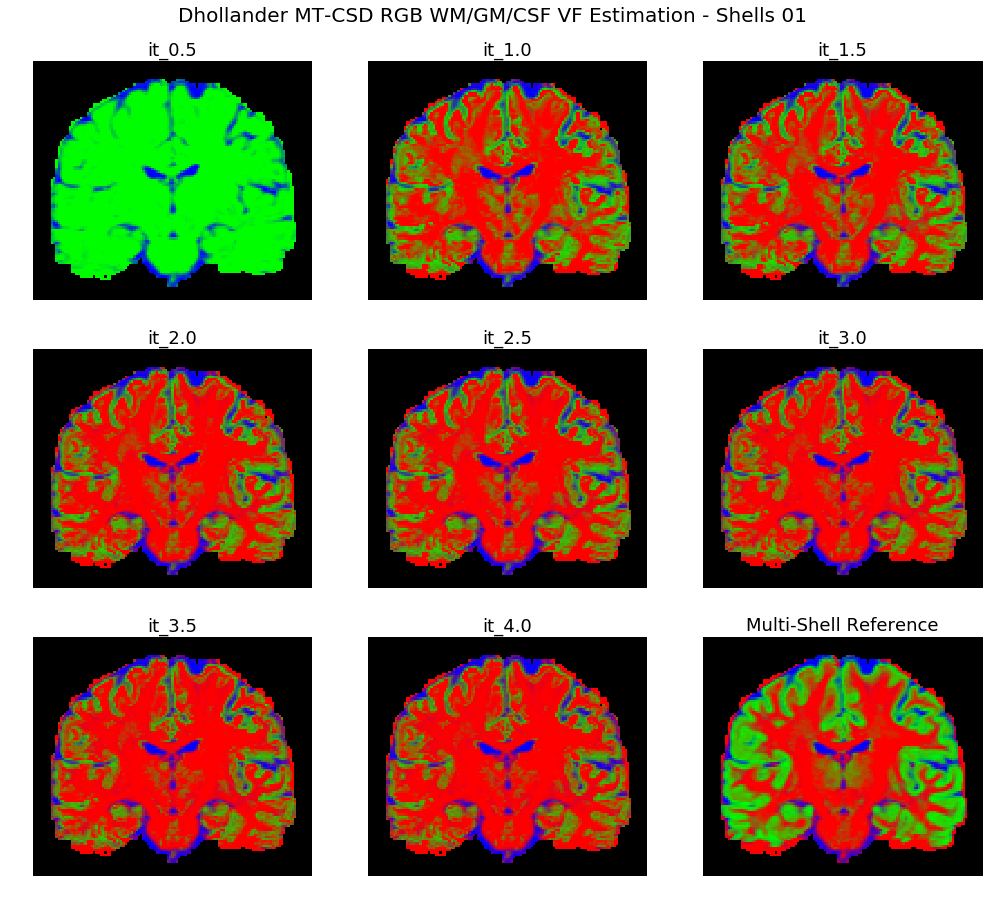

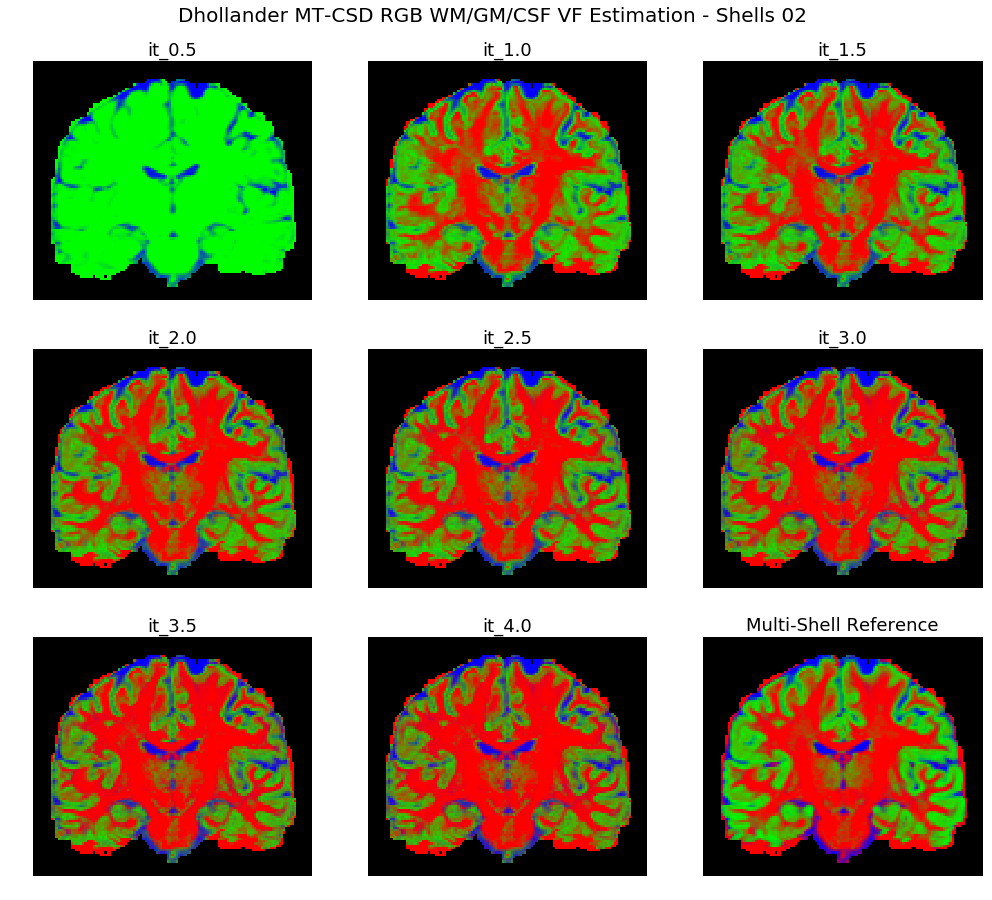

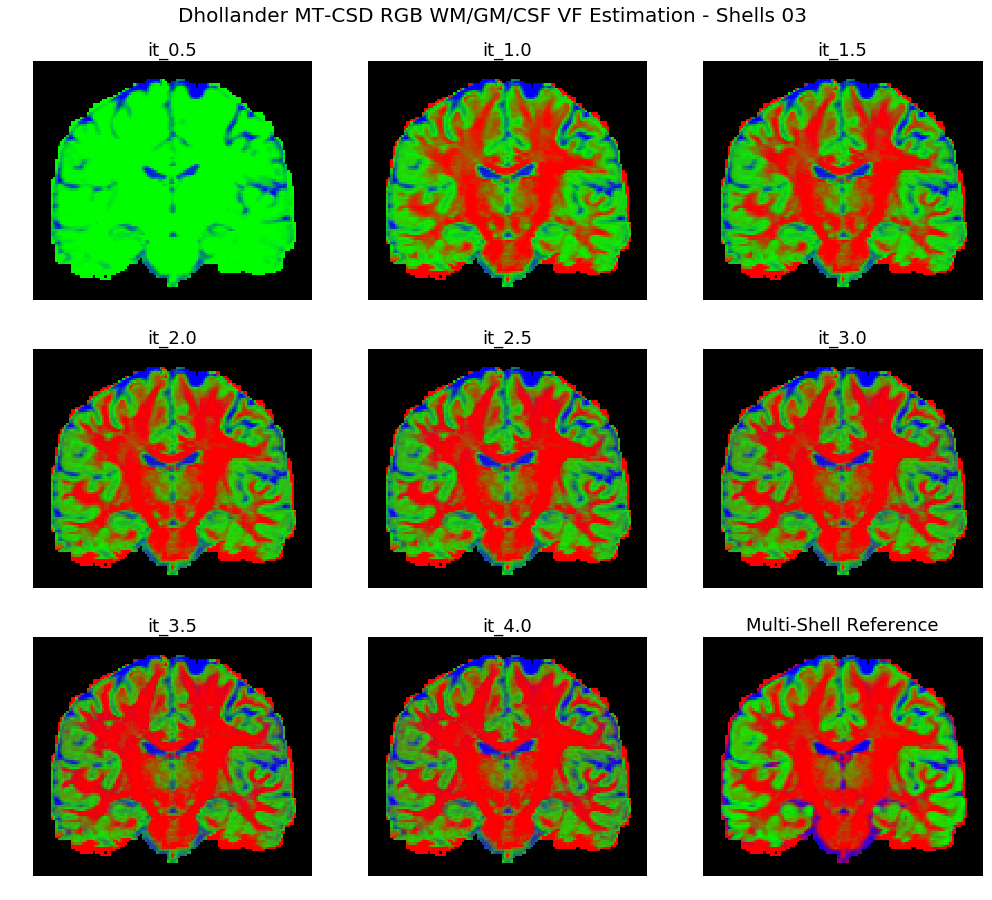

In [12]:
import numpy as np
vfs_all = []
for full_fit, title in zip(full_fits, ['Shells 01', 'Shells 02', 'Shells 03']):
    fig, axs = plt.subplots(3, 3, figsize=[17, 15])
    axs = axs.ravel()
    fig.suptitle('Dhollander MT-CSD RGB WM/GM/CSF VF Estimation - {}'.format(title), 
                 fontsize=20, y=0.93)
    for i, fit in enumerate(full_fit):
        vfs = []
        names = ['partial_volume_0', 'partial_volume_1', 'partial_volume_2']
        for name in names:
            vfs.append(fit.fitted_and_linked_parameters[name])
        vfs = np.clip(np.transpose(np.array(vfs), (3, 2, 1, 0)), 0, np.inf)
        
        vfs_sum = np.sum(vfs, axis=-1)
        vfs[vfs_sum > 0] = vfs[vfs_sum > 0] / vfs_sum[vfs_sum > 0][..., None]
        vfs_im = np.squeeze(vfs)

        axs[i].imshow(vfs_im[15:-23, 10:-10], origin=True, interpolation='nearest')
        axs[i].axis('off');
        axs[i].set_title("it_{}".format((i + 1.) / 2.), fontsize=18)
    vfs_all.append(vfs)
    
    vfs = []
    names = ['partial_volume_0', 'partial_volume_1', 'partial_volume_2']
    for name in names:
        vfs.append(mtcsd_fit_3shell.fitted_and_linked_parameters[name])
    vfs = np.transpose(np.array(vfs), (3, 2, 1, 0))
    vfs_sum = np.sum(vfs, axis=-1)
    vfs[vfs_sum > 0] = vfs[vfs_sum > 0] / vfs_sum[vfs_sum > 0][..., None]
    vfs_im = np.squeeze(np.clip(vfs, 0, 1))

    axs[-1].imshow(vfs_im[15:-23, 10:-10], origin=True, interpolation='nearest')
    axs[-1].axis('off');
    axs[-1].set_title("Multi-Shell Reference", fontsize=18)
vfs_all.append(vfs)

It can be seen that step 1 of the first iteration always consists of only GM and CSF (as we fixed WM to 0). Things to notice, that correspond with the synthetic results:
- WM increases over iterations
- GM decreases over iterations
- The b=1k data seems to have trouble finding significant GM contrast.
- Contrast looks very similar to multi-shell results for higher b-values.

## Correlation of single-shell fractions with multi-shell fractions

To get a better idea on how similar the single-shell results are to the multi-shell results, we can correlate the volume fractions over iterations for each tissue type.

We take the significant values of every tissue type (arbitrarily taken above 0.05).

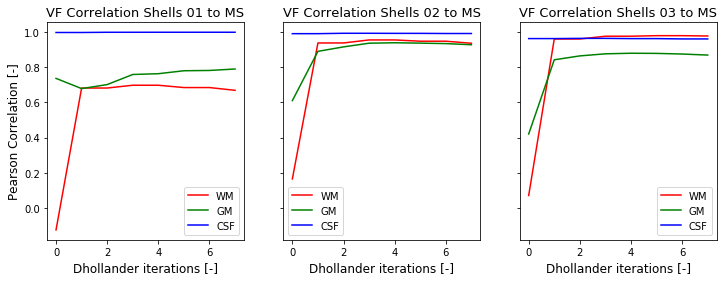

In [13]:
from scipy.stats import pearsonr
mask = data[..., 0] > 0
names = ['partial_volume_0', 'partial_volume_1', 'partial_volume_2']
txts = ['WM', 'GM', 'CSF']
titles = ['Shells 01', 'Shells 02', 'Shells 03']

fig, axs = plt.subplots(ncols=3, figsize=[12, 4], sharey=True)
axs = axs.ravel()
axs[0].set_ylabel('Pearson Correlation [-]', fontsize=12)

for i, full_fit in enumerate(full_fits):
    pearson_r_it = []
    for fit in full_fit:
        pearson_r = []
        for name in names:
            ms_result = mtcsd_fit_3shell.fitted_and_linked_parameters[name][mask]
            ss_result = fit.fitted_and_linked_parameters[name][mask]
            sig_vf_mask = ms_result > 0.05  # only correlate significant values
            pearson_r.append(pearsonr(ms_result[sig_vf_mask], ss_result[sig_vf_mask])[0])
        pearson_r_it.append(pearson_r)
    pearson_r_it = np.array(pearson_r_it).T
    
    for p_, txt, c in zip(pearson_r_it, txts, ['r', 'g', 'b']):
        axs[i].plot(p_, c=c, label=txt)
    axs[i].set_xlabel('Dhollander iterations [-]', fontsize=12)
    axs[i].legend()
    axs[i].set_title('VF Correlation {} to MS'.format(titles[i]), fontsize=13)

Notice:
- CSF correlation is very close to one even for the lowest b-value single-shell data.
- Higher b-value data generally results in better correlation.
- Using the b=3k data we can get a very good correlation of WM fraction (close to 1).
- It seems that GM is the most troublesome to get right - even using the b=3k data the correlation is around 0.8.

## Fiber Orientation Distributions Comparison

As before, we can visualize the FOD estimated using MT-CSD. We do both with and without including the S0 response.

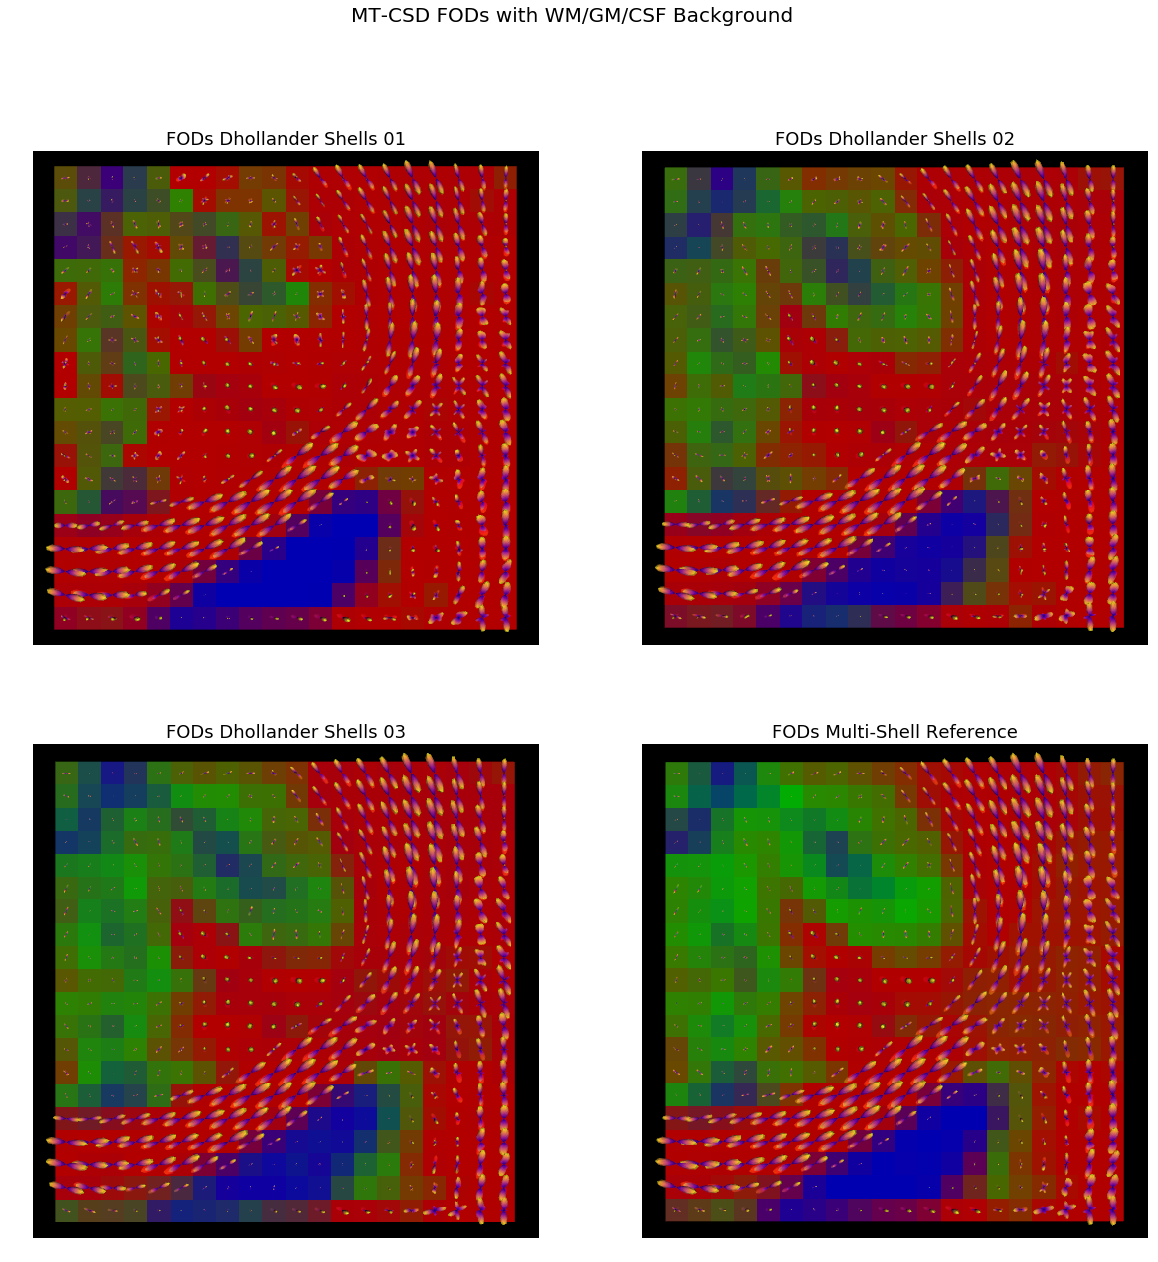

In [16]:
from dipy.data import get_sphere
from dipy.viz import window, actor
import numpy as np
import matplotlib.image as mpimg

sphere = get_sphere(name='symmetric724').subdivide()
affine = np.eye(4)

txts = ['FODs Dhollander Shells 01',
        'FODs Dhollander Shells 02', 
        'FODs Dhollander Shells 03', 
        'FODs Multi-Shell Reference']

fig, axs = plt.subplots(2, 2, figsize=[20, 20])
axs = axs.ravel()
fig.suptitle('MT-CSD FODs with WM/GM/CSF Background', fontsize=20)

viz_fits = [full_fit[-1] for full_fit in full_fits]
viz_fits.append(mtcsd_fit_3shell)

for i, (txt, vfs, fit) in enumerate(zip(txts, vfs_all, viz_fits)):
    fods = fit.fod(sphere.vertices)[70:90,:, 70:90]

    vfs2 = np.transpose(vfs, (2, 1, 0, 3))
    ai_im = actor.slicer(vfs2[70:90, 0, 70:90, None, :],
        interpolation='nearest', affine=affine, opacity=0.7)

    ren = window.Renderer()
    fod_spheres = actor.odf_slicer(fods, sphere=sphere, scale=0.9, norm=False)
    fod_spheres.display_extent(0, fods.shape[0] - 1,
                               0, fods.shape[1] - 1,
                               0, fods.shape[2] - 1)
    fod_spheres.RotateX(90)
    fod_spheres.RotateZ(180)
    fod_spheres.RotateY(180)
    ren.add(fod_spheres)
    ren.add(ai_im)
    window.record(ren, size=[700, 700])

    img = mpimg.imread('fury.png')

    axs[i].imshow(img[100:-97, 100:-85])
    axs[i].set_title(txt, fontsize=18)
    axs[i].axis('off');

Looks like single-shell three-tissue CSD works better with b0 and a higher b-value shell. Shells 03 looks remarkably similar to the 3-shell (3 shell + b0) reference.

In conclusion, it looks like the algorithm actually works (on this high quality data at least), and can be easily implemented and used in Dmipy.

## References
- Dhollander, Thijs, and Alan Connelly. "A novel iterative approach to reap the benefits of multi-tissue CSD from just single-shell (+ b= 0) diffusion MRI data." 24th International Society of Magnetic Resonance in Medicine 24 (2016): 3010.